In [1]:
pip install GPy

     |████████████████████████████████| 1.5 MB 3.3 MB/s eta 0:00:01
     |████████████████████████████████| 71 kB 20.7 MB/s eta 0:00:01
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102551 sha256=7ce96a0c6720b74fed8a431bb3a07490b35a139d52e7f67d877d8c55ccf3e407
  Stored in directory: /Users/nhatpham/Library/Caches/pip/wheels/c8/95/f5/ce28482da28162e6028c4b3a32c41d147395825b3cd62bc810
Successfully built paramz
Note: you may need to restart the kernel to use updated packages.


<b>Note:</b> I find this session very challenging in terms of maths and coding. I got the idea of covariance matrix but not too sure if I understand the GP step by step correctly. Therefore, I dont think this PCW successfully addresses all questions. But I did pay effort on the readings/video and external resources to do the PCW as much as I can.

In [21]:
import GPy
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts

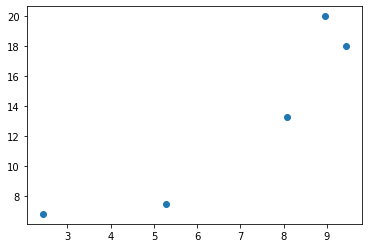

In [49]:
X = np.random.uniform(1.,10.,(5,1))
Y = X**2/8 + np.sqrt(X) + 1/2*sts.norm.rvs(5,4,size = (5,1))
plt.scatter(X,Y)

In [50]:
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)

In [51]:
m = GPy.models.GPRegression(X,Y,kernel)

In [52]:
from IPython.display import display
display(m)

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


AttributeError: 'dict' object has no attribute 'figure'

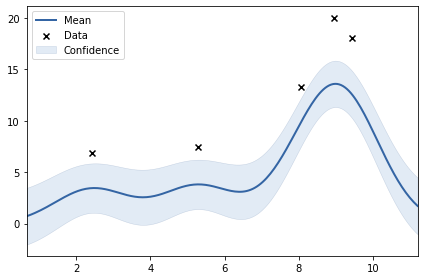

In [53]:
fig = m.plot()
GPy.plotting.show(fig, filename='basic_gp_regression_notebook')

In [54]:
m.optimize(messages=True)


In [55]:
m.optimize_restarts(num_restarts = 10)

Optimization restart 1/10, f = 16.094868545190405
Optimization restart 2/10, f = 16.094868545811906
Optimization restart 3/10, f = 16.094868545100308
Optimization restart 4/10, f = 16.09486854516251
Optimization restart 5/10, f = 16.09486854510037
Optimization restart 6/10, f = 16.094868996199928
Optimization restart 7/10, f = 16.09486854544923
Optimization restart 8/10, f = 16.094868545073933
Optimization restart 9/10, f = 16.094868545355652
Optimization restart 10/10, f = 16.094868546335963


GP_regression.,value,constraints,priors
rbf.variance,201.82508242361916,+ve,
rbf.lengthscale,5.435148842507813,+ve,
Gaussian_noise.variance,5.335387320770356,+ve,


AttributeError: 'dict' object has no attribute 'figure'

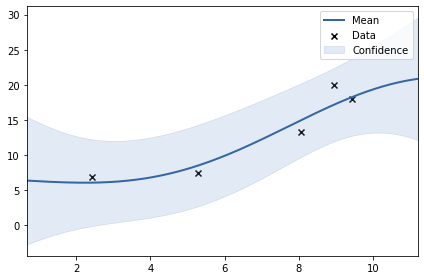

In [56]:
display(m)
fig = m.plot()
GPy.plotting.show(fig, filename='basic_gp_regression_notebook_optimized')


# 2

Automatically created module for IPython interactive environment
GPML kernel: 66**2 * RBF(length_scale=67) + 2.4**2 * RBF(length_scale=90) * ExpSineSquared(length_scale=1.3, periodicity=1) + 0.66**2 * RationalQuadratic(alpha=0.78, length_scale=1.2) + 0.18**2 * RBF(length_scale=0.134) + WhiteKernel(noise_level=0.0361)
Log-marginal-likelihood: 155.006

Learned kernel: 2.59**2 * RBF(length_scale=51) + 0.257**2 * RBF(length_scale=137) * ExpSineSquared(length_scale=2.15, periodicity=1) + 0.118**2 * RationalQuadratic(alpha=2.32, length_scale=70.6) + 0.03**2 * RBF(length_scale=1.01) + WhiteKernel(noise_level=0.001)
Log-marginal-likelihood: 1161.609


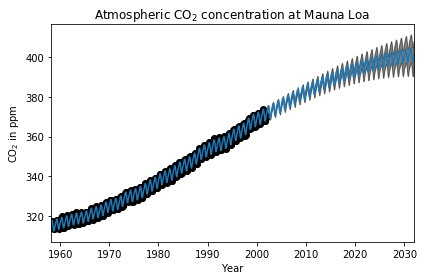

In [58]:
# Authors: Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
#
# License: BSD 3 clause


import numpy as np

from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared

print(__doc__)


def load_mauna_loa_atmospheric_co2():
    ml_data = fetch_openml(data_id=41187)
    months = []
    ppmv_sums = []
    counts = []

    y = ml_data.data[:, 0]
    m = ml_data.data[:, 1]
    month_float = y + (m - 1) / 12
    ppmvs = ml_data.target

    for month, ppmv in zip(month_float, ppmvs):
        if not months or month != months[-1]:
            months.append(month)
            ppmv_sums.append(ppmv)
            counts.append(1)
        else:
            # aggregate monthly sum to produce average
            ppmv_sums[-1] += ppmv
            counts[-1] += 1

    months = np.asarray(months).reshape(-1, 1)
    avg_ppmvs = np.asarray(ppmv_sums) / counts
    return months, avg_ppmvs


X, y = load_mauna_loa_atmospheric_co2()

# Kernel with parameters given in GPML book
k1 = 66.0**2 * RBF(length_scale=67.0)  # long term smooth rising trend
k2 = 2.4**2 * RBF(length_scale=90.0) \
    * ExpSineSquared(length_scale=1.3, periodicity=1.0)  # seasonal component
# medium term irregularity
k3 = 0.66**2 * RationalQuadratic(length_scale=1.2, alpha=0.78)
k4 = 0.18**2 * RBF(length_scale=0.134) + WhiteKernel(noise_level=0.19**2)  # noise terms
kernel_gpml = k1 + k2 + k3 + k4

gp = GaussianProcessRegressor(kernel=kernel_gpml, alpha=0, optimizer=None, normalize_y=True)
gp.fit(X, y)

print("GPML kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f"
      % gp.log_marginal_likelihood(gp.kernel_.theta))

# Kernel with optimized parameters
k1 = 50.0**2 * RBF(length_scale=50.0)  # long term smooth rising trend
k2 = 2.0**2 * RBF(length_scale=100.0) \
    * ExpSineSquared(length_scale=1.0, periodicity=1.0,
                     periodicity_bounds="fixed")  # seasonal component
# medium term irregularities
k3 = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
k4 = 0.1**2 * RBF(length_scale=0.1) \
    + WhiteKernel(noise_level=0.1**2,
                  noise_level_bounds=(1e-3, np.inf))  # noise terms
kernel = k1 + k2 + k3 + k4

gp = GaussianProcessRegressor(kernel=kernel, alpha=0,
                              normalize_y=True)
gp.fit(X, y)

print("\nLearned kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f"
      % gp.log_marginal_likelihood(gp.kernel_.theta))

X_ = np.linspace(X.min(), X.max() + 30, 1000)[:, np.newaxis]
y_pred, y_std = gp.predict(X_, return_std=True)

# Illustration
plt.scatter(X, y, c='k')
plt.plot(X_, y_pred)
plt.fill_between(X_[:, 0], y_pred - y_std, y_pred + y_std,
                 alpha=0.5, color='k')
plt.xlim(X_.min(), X_.max())
plt.xlabel("Year")
plt.ylabel(r"CO$_2$ in ppm")
plt.title(r"Atmospheric CO$_2$ concentration at Mauna Loa")
plt.tight_layout()
plt.show()